# Conceitos de underfitting, overfitting e regularização

Esse tutorial visa explicar os conceitos de *underfitting*, *overfitting* e regularização através de um exemplo de ajuste de curva usando o keras.

*Underfitting* ocorre quando o modelo não é capaz de representar a natureza dos dados. Normalmente resolve-se o *underfitting* aumentando a complexidade do modelo de ajuste; em redes neurais, isso é equivalente a aumentar o número de camadas e o número de neurônios por camada.

*Overfitting* ocorre quando o modelo se adequa excessivamente aos dados de entrada, de forma que ele se torna específico demais para os dados de treinamento e torna-se incapaz de generalizar para novos dados.

Regularização é uma técnica para evitar o *overfitting*.

O tutorial é uma adaptação do exemplo apresentado no capítulo 1 do livro:
"Christopher M. Bishop. 2006. Pattern Recognition and Machine Learning (Information Science and Statistics). Springer-Verlag New York, Inc., Secaucus, NJ, USA."

# Função de custo com regularização L2_reg

$$\Large E(\boldsymbol{w})=\frac{1}{2}\sum_{n=1}^N\{\hat{y}(x_n,\boldsymbol{w})-y_n\}^2 +\frac{\lambda}{2}||\boldsymbol{W}||^2$$

# Importação das bibliotecas - NumPy, matplotlib e ipywidgets

In [2]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

# Funções para exibição dos resultados e realização dos treinamentos

In [3]:
FIGSIZE = (8, 4)
DPI = 100
PATIENCE = 10000
CUDA = False

d_loss = dict()

def show_model_results(fig, x_orig, y_orig, x_train, y_train, x_test, y_test, loss=None, y_predict=None, n_epochs=None):
    x_orig = x_orig.data.cpu().numpy().reshape(-1,)
    y_orig = y_orig.data.cpu().numpy().reshape(-1,)
    x_train = x_train.data.cpu().numpy().reshape(-1,)
    y_train = y_train.data.cpu().numpy().reshape(-1,)
    x_test = x_test.data.cpu().numpy().reshape(-1,)
    y_test = y_test.data.cpu().numpy().reshape(-1,)
    if y_predict is not None:
        y_predict = y_predict.data.cpu().numpy().reshape(-1,)
    loss = loss.data[0]

    # Gráfico do sinal sem ruído, dos conjuntos de treinamento e de teste, e o ajuste
    plt.cla()
    ax1 = fig.add_subplot(1, 1, 1)
    title = ''
    if n_epochs is not None:
        title += 'Epochs: {}   '.format(n_epochs)
    if loss is not None:
        title += 'Loss: {:.4f}'.format(loss)
    if len(title) != 0:
        ax1.set_title(title)
    ax1.plot(x_orig, y_orig, linewidth=2.0, label=r'Modelo: $sin(2 \pi x)$')
    if y_predict is not None:
        ax1.plot(x_train, y_predict, linewidth=2.0, label='Ajuste')
    # ax1.plot(x_test, y_test, 'x', color='black', label = "Teste")
    ax1.plot(x_train, y_train, 'o', color='red', label = "Treinamento")
    ax1.legend()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    fig.canvas.draw()

def get_model(n_hidden_neurons=0):
    n_hidden_neurons = int(n_hidden_neurons)
    if n_hidden_neurons < 0:
        raise ValueError('n_hidden_neurons must be zero or positive')
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            if n_hidden_neurons == 0:
                self.linr01 = nn.Linear(in_features=1, out_features=1)
            else:
                self.linr01 = nn.Linear(in_features=1, out_features=n_hidden_neurons)
                self.linr02 = nn.Linear(in_features=n_hidden_neurons, out_features=1)
        def forward(self, x):
            if n_hidden_neurons == 0:
                x = self.linr01(x)
            else:
                x = F.sigmoid(self.linr01(x))
                x = self.linr02(x)
            return x
    net = Net()
    if torch.cuda.is_available() and CUDA:
        net.cuda()
    return net

def train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test):
    net.train()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.RMSprop(params=net.parameters(), lr=0.5e-2, weight_decay=reg_factor)
    i_epoch = 0
    i_best = 0
    loss_best = np.inf
    d_state_best = net.state_dict()
    train = True
    while train:
        try:
            y_predict = net(x_train)
            loss = criterion(y_predict, y_train)
            if loss.data[0] < loss_best:
                loss_best = loss.data[0]
                i_best = i_epoch
                d_state_best = net.state_dict()
            if PATIENCE < i_epoch - i_best:
                net.load_state_dict(d_state_best)
                net.eval()
                y_predict = net(x_train)
                show_model_results(fig, x_orig, y_orig, x_train, y_train, x_test, y_test, loss, y_predict, i_best)
                break
            if i_epoch % 2000 == 0:
                show_model_results(fig, x_orig, y_orig, x_train, y_train, x_test, y_test, loss, y_predict, i_epoch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            i_epoch += 1
            if i_epoch > 50000:
                break
        except KeyboardInterrupt:
            train = False
    print('Finished training.')

# Gerando dados sintéticos com ruído
São gerados 10 pontos de treinamento (representados pelos pontos marcados com círculos vermelhos no gráfico) e 100 pontos de teste (representados pelos pontos marcados com cruzes pretas). O objetivo é treinar usando os pontos vermelhos e testar usando os pontos pretos.

In [4]:
def generate_dataset(n_points=15, noise_stdev=0.3, rnd_seed=42):
    torch.manual_seed(rnd_seed)

    train_size = n_points
    test_size = n_points

    # Ruido gaussiano
    noise_mean = torch.zeros(train_size)
    noise_std = noise_stdev

    x_true = torch.linspace(0.0, 1.0, 100)
    y_true = torch.sin(2.0 * np.pi * x_true)

    x_samples = torch.linspace(0.0, 1.0, 2 * n_points + 20)
    idx = torch.randperm(2 * n_points + 20)
    tra_idx = idx[:train_size]
    tst_idx = idx[-test_size:]

    # Conjunto de validação
    # x_test = torch.rand(test_size, 1)
    x_test = x_samples[tst_idx].view(-1, 1)
    y_test = torch.sin(2.0 * np.pi * x_test[:, 0]) + torch.normal(noise_mean, noise_std)

    # Conjunto de treino
    # x_train = torch.rand(train_size, 1)
    x_train = x_samples[tra_idx].view(-1, 1)
    y_train = torch.sin(2.0 * np.pi * x_train[:, 0]) + torch.normal(noise_mean, noise_std)
    
    return x_true, y_true, x_train, y_train, x_test, y_test


In [49]:
class Net(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(Net, self).__init__()
        self.n_hidden = n_hidden_neurons
        if n_hidden_neurons == 0:
            self.linear01 = nn.Linear(in_features=1, out_features=1)
        else:
            self.linear01 = nn.Linear(in_features=1, out_features=n_hidden_neurons)
            self.linear02 = nn.Linear(in_features=n_hidden_neurons, out_features=1)
            
    def forward(self, x):
        if self.n_hidden == 0:
            x = self.linear01(x)
        else:
            x = self.linear01(x)
            x = F.sigmoid(x)
            x = self.linear02(x)
        return x

def train_model(model, x_train, y_train, x_test, y_test, lr=0.1, reg_factor=0.0, n_epochs=100, use_gpu=False):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=reg_factor)
    
    if use_gpu:
        model = model.cuda()
        x_train, y_train = Variable(x_train.cuda()), Variable(y_train.cuda())
        x_test, y_test = Variable(x_test.cuda()), Variable(y_test.cuda())
    else:
        x_train, y_train = Variable(x_train), Variable(y_train)
        x_test, y_test = Variable(x_test), Variable(y_test)

    train_losses = []
    test_losses = []
    train_preds = []
    test_preds = []
    for i in range(n_epochs):
        try:
            model.train(True)
            optimizer.zero_grad()
            train_pred = model(x_train)
            train_loss = criterion(train_pred, y_train)
            train_loss.backward()
            optimizer.step()
            
            model.train(False)
            test_pred = model(x_test)
            test_loss = criterion(test_pred, y_test)
            
            train_losses.append(train_loss.data[0])
            test_losses.append(test_loss.data[0])
            
            train_preds.append(train_pred.data)
            test_preds.append(test_pred.data)
            
        except KeyboardInterrupt:
            print('Training interrupted!')
            break
            
    # print('Training finished.')
    return train_losses, test_losses, train_preds, test_preds


In [52]:
import ipywidgets as widgets

def show_network_plots(n_data=15, noise=0.3, neurons=16, epochs=500, lr=0.1, L2_reg=0.0, t_train=False, t_test=False):
    
    model = Net(neurons)
    x_true, y_true, x_train, y_train, x_test, y_test = generate_dataset(n_points=n_data, noise_stdev=noise)
    tra_loss, tst_loss, tra_preds, tst_preds = train_model(model, x_train, y_train, x_test, y_test, 
                                                           lr=lr, reg_factor=L2_reg, n_epochs=epochs)

    fig = plt.figure(figsize=(15,4))

    fig.add_subplot(1, 2, 1)
    plt.plot(tra_loss, color='blue', label='training')
    plt.plot(tst_loss, color='red', label='validation')
    plt.ylim(0, 1.0)
    plt.grid()
    plt.legend()

    print('Losses:  T={:.5f},  V={:.5f}'.format(tra_loss[-1], tst_loss[-1]))

    fig.add_subplot(1, 2, 2)
    plt.plot(x_true.numpy(), y_true.numpy(), color='orange')
    plt.plot(x_train.numpy(), tra_preds[-1].numpy(), 'o', color='blue', label='training')
    plt.plot(x_test.numpy(), tst_preds[-1].numpy(), 'o', color='red', label='validation')
    if t_train:
        plt.plot(x_train.numpy(), y_train.numpy(), 'x', color='blue')
    if t_test:
        plt.plot(x_test.numpy(), y_test.numpy(), 'x', color='red')
    plt.ylim(-1.6, 1.6)
    plt.grid()
    plt.legend()
    

def showIt(n_data=15, noise=0.3, neurons=16, epochs=400, lr=0.1, L2_reg=0.0, t_train=False, t_test=False):
    s_ndata = widgets.IntSlider(min=10, max=20, step=1, value=n_data, continuous_update=False)
    s_epochs = widgets.IntSlider(min=10, max=500, step=10, value=epochs, continuous_update=False)
    s_neurons = widgets.IntSlider(min=0, max=32, step=1, value=neurons, continuous_update=False)

    s_noise = widgets.FloatSlider(min=0.1, max=0.5, step=0.1, value=noise, readout_format='.1f', continuous_update=False)
    s_lr = widgets.FloatSlider(min=0.01, max=0.1, step=0.01, value=lr, readout_format='.3f', continuous_update=False)
    s_L2_reg = widgets.FloatSlider(min=0.0, max=0.005, step=0.0001, value=L2_reg, readout_format='.4f', continuous_update=False)
    
    widgets.interact(show_network_plots, epochs=s_epochs, noise=s_noise, neurons=s_neurons, lr=s_lr, L2_reg=s_L2_reg);    

## Underfitting

Losses:  T=0.28611,  V=0.27572


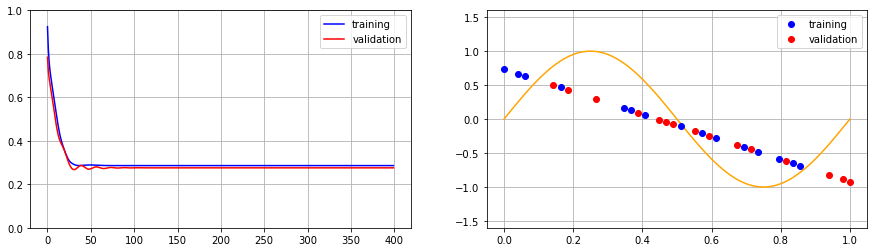

In [56]:
showIt(neurons=0)

## Overfitting

Losses: 0.05773,  0.19969


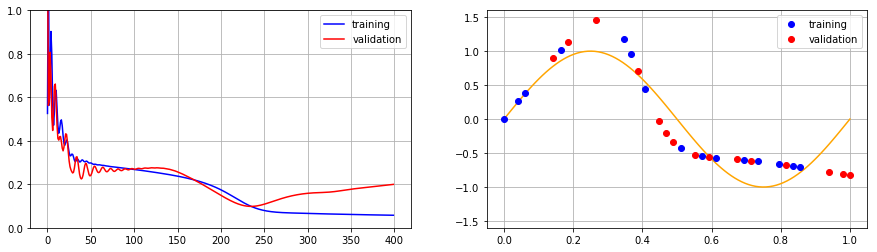

In [47]:
showIt()

## Early Stopping

Training finished.
Losses: 0.09201,  0.09932


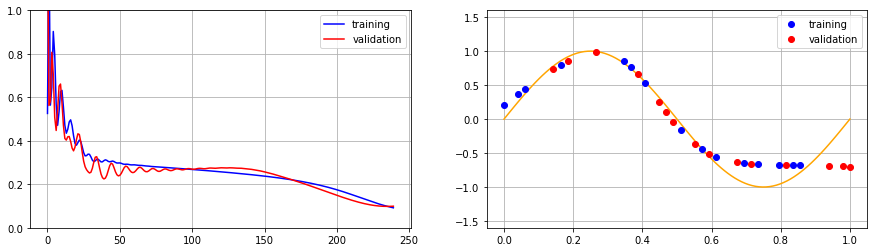

In [46]:
showIt(epochs=240)

## Regularização

Losses: 0.08760,  0.15260


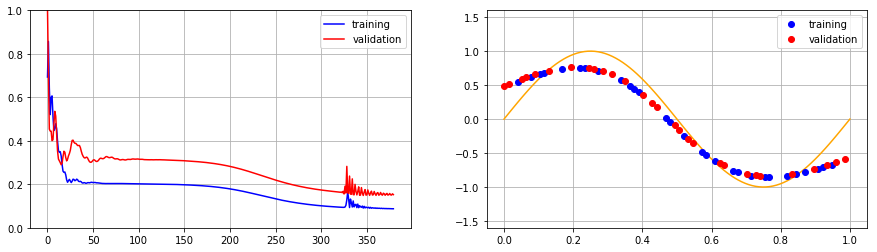

In [45]:
showIt(L2_reg=0.001)

<IPython.core.display.Javascript object>


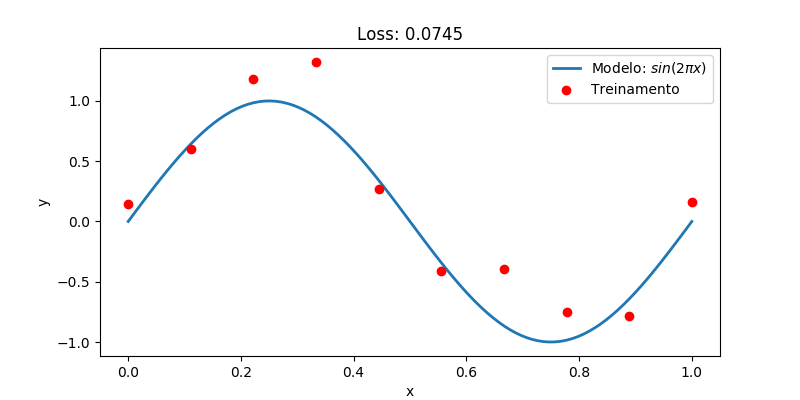

In [26]:
# Conjunto de teste
test_size = 100
x_test = np.linspace(0.0, 1.0, test_size)
y = np.sin(2.0 * np.pi * x_test)
y_test = y + np.random.normal(0.0, noise_var test_size) # sinal + ruido

x_orig = x_test
y_orig = y

x_train = torch.from_numpy(x_train.reshape(-1, 1)).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.reshape(-1, 1)).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test.reshape(-1, 1)).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.reshape(-1, 1)).type(torch.FloatTensor)
x_orig = torch.from_numpy(x_orig.reshape(-1, 1)).type(torch.FloatTensor)
y_orig = torch.from_numpy(y_orig.reshape(-1, 1)).type(torch.FloatTensor)

if torch.cuda.is_available() and CUDA:
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    x_orig = x_orig.cuda()
    y_orig = y_orig.cuda()

x_train = Variable(x_train)
y_train = Variable(y_train)
x_test = Variable(x_test)
y_test = Variable(y_test)
x_orig = Variable(x_orig)
y_orig = Variable(y_orig)

criterion = torch.nn.MSELoss()
loss = criterion(y_orig, y_test)

# Gráfico do sinal sem ruído, e dos conjuntos de treinamento e de teste
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
show_model_results(fig, x_orig, y_orig, x_train, y_train, x_test, y_test, loss)

<IPython.core.display.Javascript object>


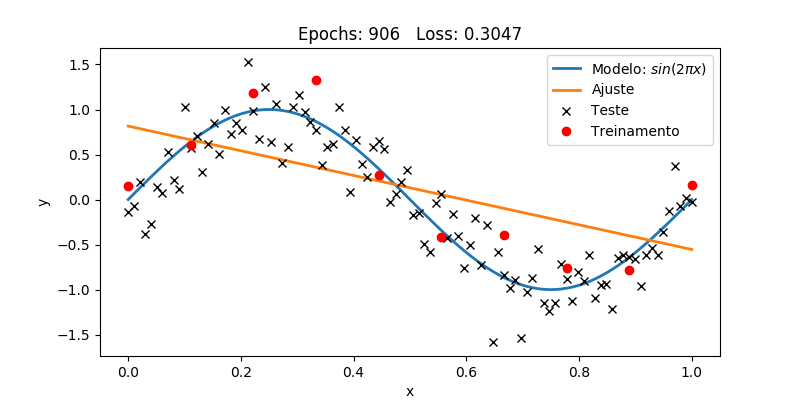

Finished training.


In [22]:
n_hidden_neurons = 0
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


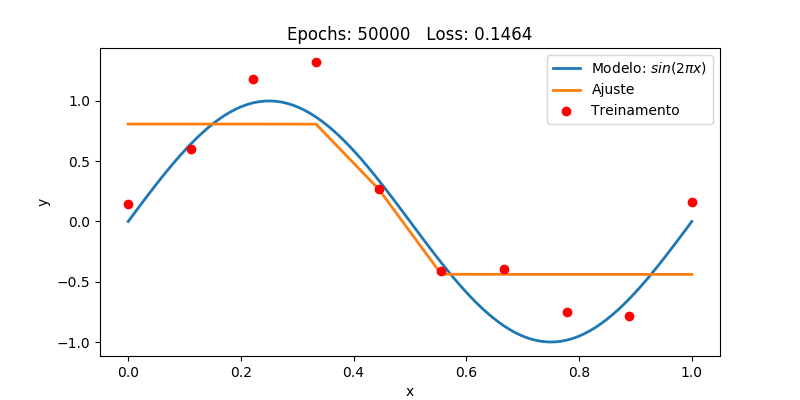

Finished training.


In [27]:
n_hidden_neurons = 1
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


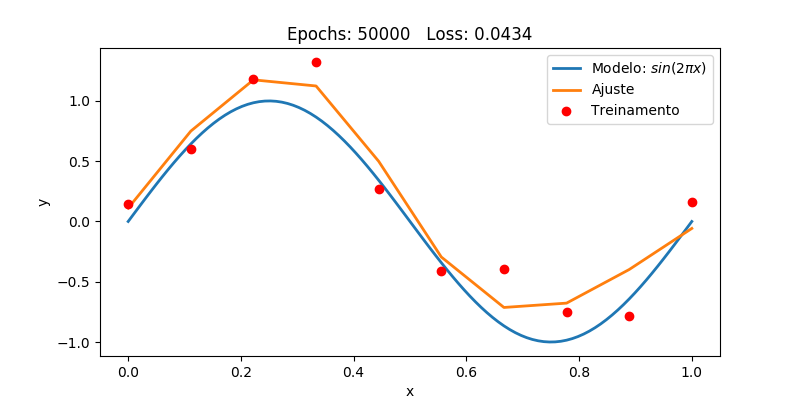

Finished training.


In [28]:
n_hidden_neurons = 2
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


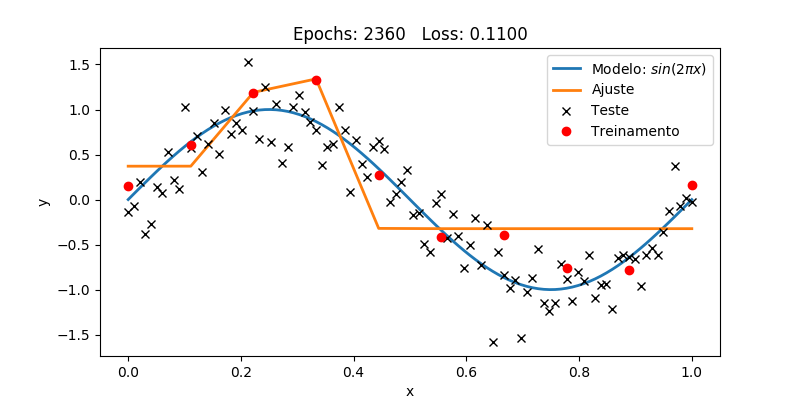

Finished training.


In [7]:
n_hidden_neurons = 4
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


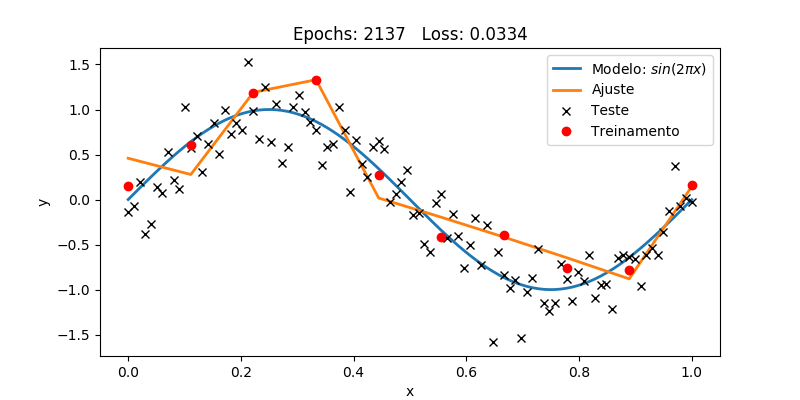

Finished training.


In [8]:
n_hidden_neurons = 8
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


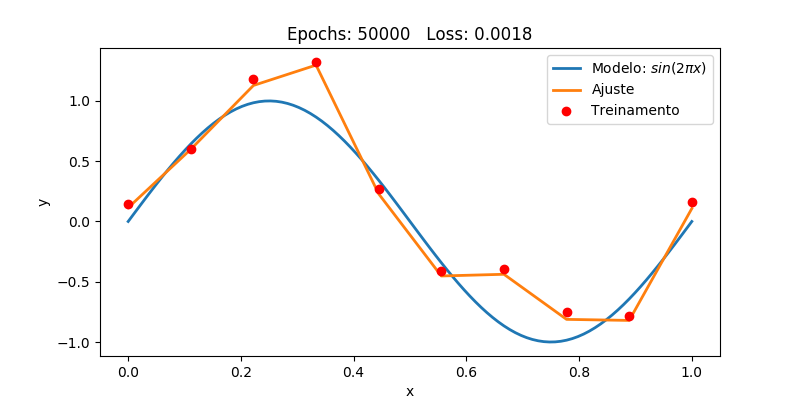

Finished training.


In [29]:
n_hidden_neurons = 16
reg_factor = 0.
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


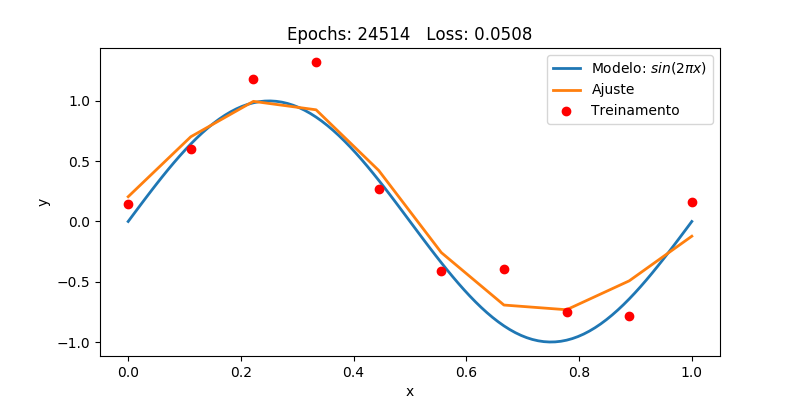

Finished training.


In [34]:
n_hidden_neurons = 16
reg_factor = 0.001
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


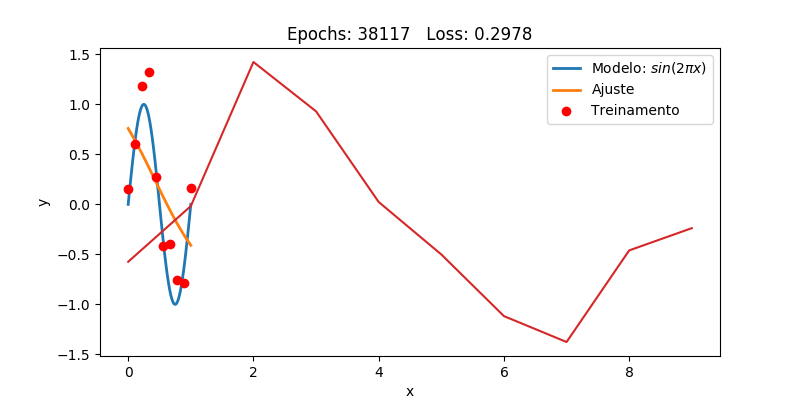

Finished training.


In [35]:
n_hidden_neurons = 16
reg_factor = 0.01
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


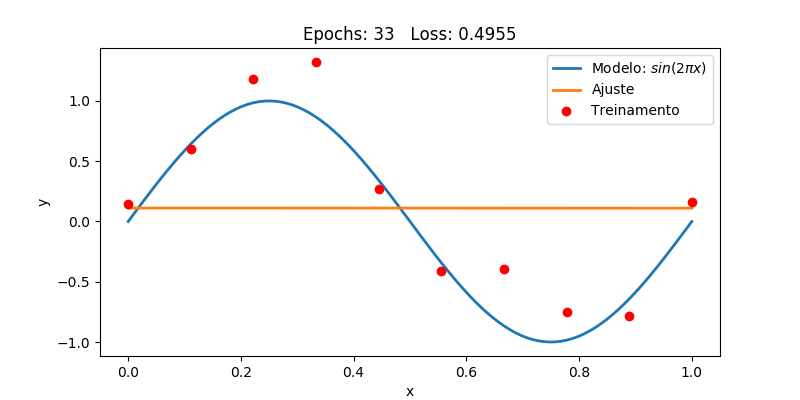

Finished training.


In [32]:
n_hidden_neurons = 16
reg_factor = 0.1
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


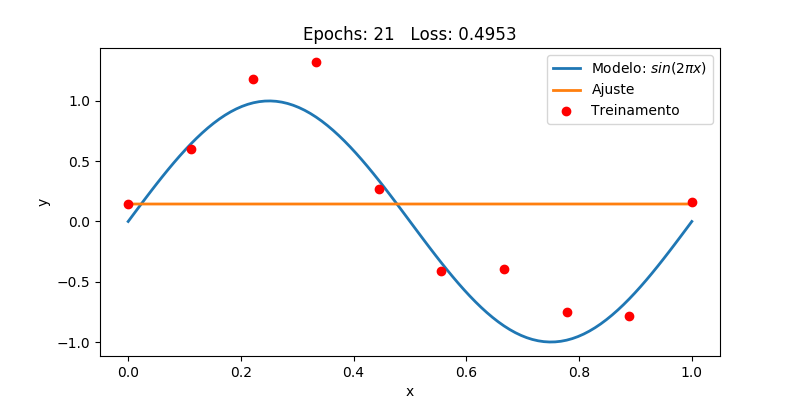

Finished training.


In [31]:
n_hidden_neurons = 16
reg_factor = 1.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


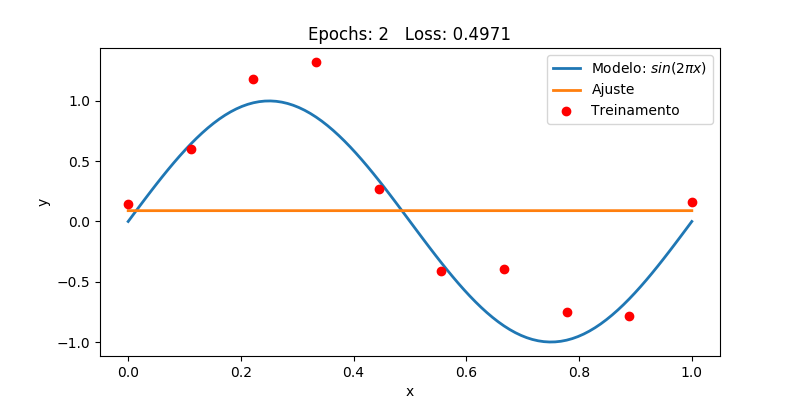

Finished training.


In [33]:
n_hidden_neurons = 16
reg_factor = 10.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


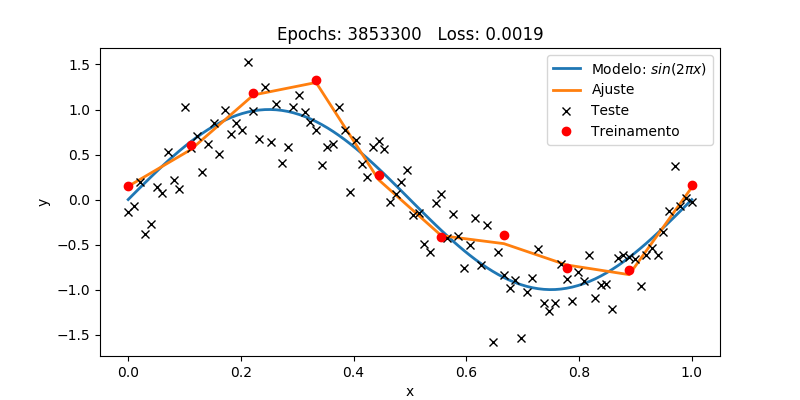

Finished training.


In [15]:
n_hidden_neurons = 16
reg_factor = 100.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


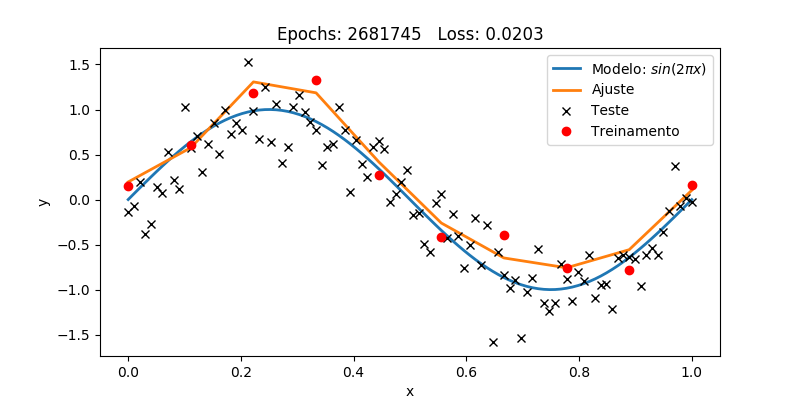

Finished training.


In [16]:
n_hidden_neurons = 16
reg_factor = 100.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


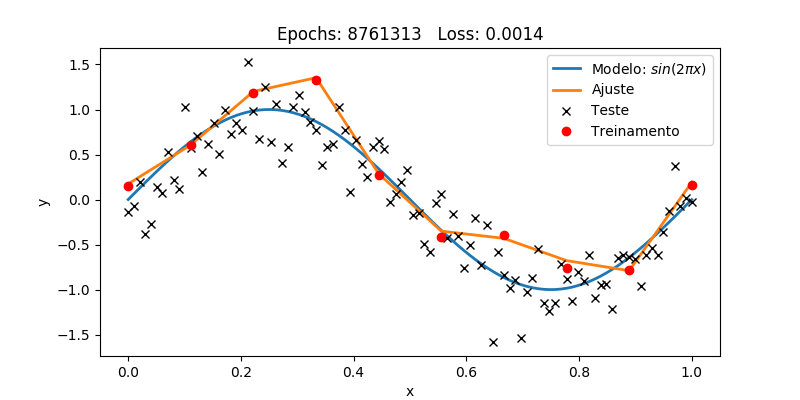

Finished training.


In [17]:
n_hidden_neurons = 16
reg_factor = 200.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)

<IPython.core.display.Javascript object>


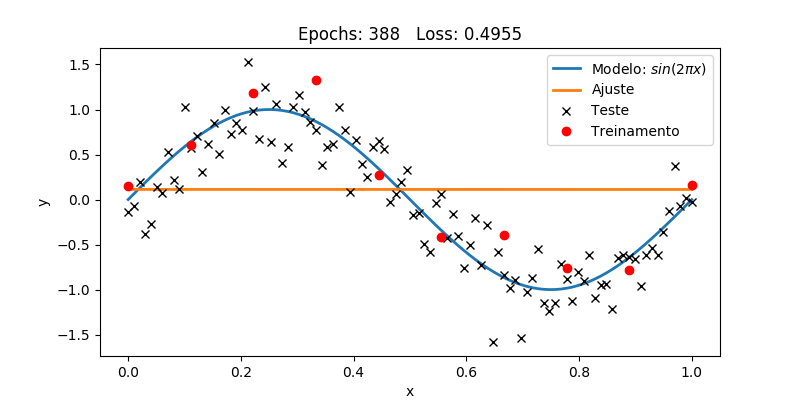

Finished training.


In [18]:
n_hidden_neurons = 16
reg_factor = 1000.0
net = get_model(n_hidden_neurons)
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)

n, f = n_hidden_neurons, reg_factor
d_loss[(n, f)] = train_model(net, reg_factor, fig, x_orig, y_orig, x_train, y_train, x_test, y_test)